In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import tqdm
import math
from DatasetCreator import create_data_vahadane
from tqdm import tqdm_notebook as tqdm 
from PatchExtractor import PatchExtractor
from Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import U_Net, save_model,load_model,init_weights
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,DE_loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle

from PredictNucleiMask import whole_img_pred


In [2]:
png_dir='norm_ideal'
annotation_dir='Annotations'
nucleus_dir='processed_data/nucleus_maps'
boundary_dir='processed_data/boundary_maps'

h_e_train_dir='processed_data/h_e_train_dir'
h_train_dir='processed_data/h_train_dir'
nuclei_mask_train_dir='processed_data/nuclei_mask_train_dir'
boundary_mask_train_dir='processed_data/boundary_mask_train_dir'

h_e_test_dir='processed_data/h_e_test_dir'
h_test_dir='processed_data/h_test_dir'
nuclei_mask_test_dir='processed_data/nuclei_mask_test_dir'
boundary_mask_test_dir='processed_data/boundary_mask_test_dir'

h_e_train_patch_dir='processed_data/h_e_train_patch_dir'
h_train_patch_dir='processed_data/h_train_patch_dir'
nuclei_mask_train_patch_dir='processed_data/nuclei_mask_train_patch_dir'
boundary_mask_train_patch_dir='processed_data/boundary_mask_train_patch_dir'

h_e_test_patch_dir='processed_data/h_e_test_patch_dir'
h_test_patch_dir='processed_data/h_test_patch_dir'
nuclei_mask_test_patch_dir='processed_data/nuclei_mask_test_patch_dir'
boundary_mask_test_patch_dir='processed_data/boundary_mask_test_patch_dir'


In [3]:
train_list=['TCGA-A7-A13E-01Z-00-DX1.png',\
'TCGA-A7-A13F-01Z-00-DX1.png',\
'TCGA-AR-A1AK-01Z-00-DX1.png',\
'TCGA-AR-A1AS-01Z-00-DX1.png',\
'TCGA-18-5592-01Z-00-DX1.png',\
'TCGA-38-6178-01Z-00-DX1.png',\
'TCGA-49-4488-01Z-00-DX1.png',\
'TCGA-50-5931-01Z-00-DX1.png',\
'TCGA-HE-7130-01Z-00-DX1.png',\
'TCGA-HE-7129-01Z-00-DX1.png',\
'TCGA-B0-5711-01Z-00-DX1.png',\
'TCGA-B0-5698-01Z-00-DX1.png',\
'TCGA-G9-6362-01Z-00-DX1.png',\
'TCGA-G9-6336-01Z-00-DX1.png',\
'TCGA-G9-6363-01Z-00-DX1.png',\
'TCGA-G9-6356-01Z-00-DX1.png']

test_list=list(set([x for x in os.listdir(png_dir) if x.split('.')[-1].lower()=='png'])-set(train_list))

# TRAIN

TCGA-A7-A13E-01Z-00-DX1.png<br/>
TCGA-A7-A13F-01Z-00-DX1.png<br/>
TCGA-AR-A1AK-01Z-00-DX1.png<br/>
TCGA-AR-A1AS-01Z-00-DX1.png<br/>
TCGA-18-5592-01Z-00-DX1.png<br/>
TCGA-38-6178-01Z-00-DX1.png<br/>
TCGA-49-4488-01Z-00-DX1.png<br/>
TCGA-50-5931-01Z-00-DX1.png<br/>
TCGA-HE-7130-01Z-00-DX1.png<br/>
TCGA-HE-7129-01Z-00-DX1.png<br/>
TCGA-B0-5711-01Z-00-DX1.png<br/>
TCGA-B0-5698-01Z-00-DX1.png<br/>
TCGA-G9-6362-01Z-00-DX1.png<br/>
TCGA-G9-6336-01Z-00-DX1.png<br/>
TCGA-G9-6363-01Z-00-DX1.png<br/>
TCGA-G9-6356-01Z-00-DX1.png


# TEST

TCGA-E2-A14V-01Z-00-DX1.png<br/>
TCGA-G2-A2EK-01A-02-TSB.png<br/>
TCGA-21-5786-01Z-00-DX1.png<br/>
TCGA-CH-5767-01Z-00-DX1.png<br/>
TCGA-AY-A8YK-01A-01-TS1.png<br/>
TCGA-G9-6348-01Z-00-DX1.png<br/>
TCGA-B0-5710-01Z-00-DX1.png<br/>
TCGA-KB-A93J-01A-01-TS1.png<br/>
TCGA-RD-A8N9-01A-01-TS1.png<br/>
TCGA-21-5784-01Z-00-DX1.png<br/>
TCGA-E2-A1B5-01Z-00-DX1.png<br/>
TCGA-DK-A2I6-01A-01-TS1.png<br/>
TCGA-NH-A8F7-01A-01-TS1.png<br/>
TCGA-HE-7128-01Z-00-DX1.png

900
788


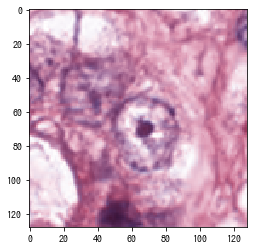

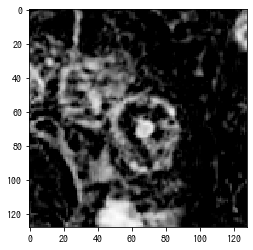

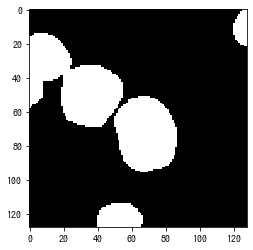

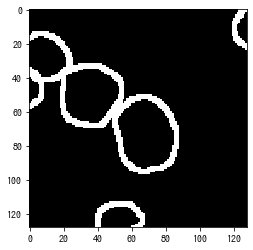

In [8]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                Scale(),\
                                                ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,1)

In [9]:
model=U_Net(img_ch=3,output_ch=1,dropout=0.45)
# model=AttnUNet(img_ch=2,output_ch=1,dropout=0.5)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'Unet_model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/Unet_model_2020_01_24 dir has been made
Model's state_dict:
Conv1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1.conv.0.bias 	 torch.Size([64])
Conv1.conv.1.weight 	 torch.Size([64])
Conv1.conv.1.bias 	 torch.Size([64])
Conv1.conv.1.running_mean 	 torch.Size([64])
Conv1.conv.1.running_var 	 torch.Size([64])
Conv1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1.conv.3.bias 	 torch.Size([64])
Conv1.conv.4.weight 	 torch.Size([64])
Conv1.conv.4.bias 	 torch.Size([64])
Conv1.conv.4.running_mean 	 torch.Size([64])
Conv1.conv.4.running_var 	 torch.Size([64])
Conv1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2.conv.0.bias 	 torch.Size([128])
Conv2.conv.1.weight 	 torch.Size([128])
Conv2.conv.1.bias 	 torch.Size([128])
Conv2.conv.1.running_mean 	 torch.Size([128])
Conv2.conv.1.running_var 	 torch.Size([128])
Conv2.conv.1.num_batches_tra

In [10]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=True
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()
# criterion=MultiClassBCE(weights=[0.65,0.35])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98),weight_decay=0.002)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=0, min_lr=10e-08, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='Unet_model_2020_01_23/model_optim_dice.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                

                h_e_train,nuclei_mask_train= sample_batched['h_e'],sample_batched['nuclei_mask']
                
                
                h_e_train,nuclei_mask_train= \
                h_e_train.to(device, dtype = torch.float),nuclei_mask_train.to(device, dtype = torch.float)

                gt_mask_train=nuclei_mask_train

                # forward + backward + optimize

                outputs = torch.sigmoid(model(h_e_train))

                pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%100==0:
                    
                    img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                    
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
#                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + i+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):

#
                h_e_test,nuclei_mask_test= test_sample['h_e']\
                ,test_sample['nuclei_mask']

                h_e_test,nuclei_mask_test = \
                h_e_test.to(device, dtype = torch.float),nuclei_mask_test.to(device, dtype = torch.float)

                gt_mask_test=nuclei_mask_test
                test_outputs = torch.sigmoid(model(h_e_test))

                pred_nuclei_test=test_outputs
                
                test_loss = criterion(test_outputs, gt_mask_test)
                
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    
    
                    img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    
#                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + i+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("history.txt", "wb") as fp:   #Pickling
    pickle.dump(history, fp)

Tesla V100-SXM2-32GB
Done loading
Learning Rate : 0.001



test_loss: 0.2514290529694785
test_dice :0.6734617109575929
saved model with test dice score: 0.6734617109575929
Learning Rate : 0.001



test_loss: 0.23923391369342006
test_dice :0.6746968951920909
saved model with test dice score: 0.6746968951920909
Learning Rate : 0.001



test_loss: 0.238448612535225
test_dice :0.7120028424336209
saved model with test dice score: 0.7120028424336209
Learning Rate : 0.001




test_loss: 0.23854955815325224
test_dice :0.6796089381723847
Learning Rate : 0.001



test_loss: 0.22995187112865273
test_dice :0.7264213687885817
saved model with test dice score: 0.7264213687885817
Learning Rate : 0.001



test_loss: 0.2344350174337973
test_dice :0.67755612713316
Learning Rate : 0.001



test_loss: 0.2322110427142343
test_dice :0.6948365907797898
Learning Rate : 0.001



test_loss: 0.24221895946681732
test_dice :0.6692883269382309
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Learning Rate : 0.0001



test_loss: 0.22276915986003387
test_dice :0.7232505101689582
Learning Rate : 0.0001



test_loss: 0.22657167318338833
test_dice :0.7195475523875661
Learning Rate : 0.0001



test_loss: 0.22722266289740503
test_dice :0.7148722590648904
Learning Rate : 0.0001



test_loss: 0.22728081464477026
test_dice :0.7130719146675941
Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate : 1e-05



test_loss: 0.2239893942435615
test_dice :0.718474292442184
Learning Rate : 1e-05



test_loss: 0.22485579386774618
test_dice :0.7214534475554906
Learning Rate : 1e-05



test_loss: 0.2266038420163602
test_dice :0.7233326141048331
Epoch    15: reducing learning rate of group 0 to 1.0000e-06.
Learning Rate : 1.0000000000000002e-06



test_loss: 0.22704375887588377
test_dice :0.7185958252345344
Learning Rate : 1.0000000000000002e-06



test_loss: 0.2279298160314653
test_dice :0.7198911718395749
Learning Rate : 1.0000000000000002e-06



test_loss: 0.22712770865419163
test_dice :0.718687188082391
Epoch    18: reducing learning rate of group 0 to 1.0000e-07.
Learning Rate : 1.0000000000000002e-07



test_loss: 0.22796238045027492
test_dice :0.7250514407381152
Learning Rate : 1.0000000000000002e-07



test_loss: 0.22613812830272723
test_dice :0.7166053331082698
Learning Rate : 1.0000000000000002e-07


KeyboardInterrupt: 

In [ ]:

# model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2)
# filename='model_2020_01_16/model_optim.pth'
# pred_dir_name='predictionv2'
# # test_list=os.listdir('test_data/norm_ideal')
# load_model(filename,model,optimizer=None,scheduler=None)
# for img_name in ['TCGA-B0-5710-01Z-00-DX1.png']:
#     h_e_path=os.path.join('norm_ideal',img_name)
#     h_path=os.path.join('H_gray',img_name)
#     whole_img_pred(h_e_path,h_path,pred_dir_name,model,print_prompt=False)
    
# print("DONE")

In [ ]:
!rm -rf Unet_model_2020_01_24

In [ ]:
!ls